# Predictions for Bitcoin

In [11]:
import yfinance as yf
import ta
from sklearn.ensemble import RandomForestRegressor
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.models import NaiveDrift, NaiveSeasonal, TCNModel, BlockRNNModel, TransformerModel, TFTModel
import matplotlib.pyplot as plt
import numpy as np
import torch
import plotly.graph_objects as go
from darts.metrics import mae, rmse, mse, mape
from pytorch_lightning.callbacks import EarlyStopping





torch.manual_seed(1)
np.random.seed(1)



In [12]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph(actual, prediction, print_single, model):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = "Bitcoin prices")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [13]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph_backtesting(actual, prediction, print_single, model, horizon):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = f"Backtesting for Bitcoin prices with Forecasting Horizon = {horizon}")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [14]:
#retrieve bitcoin data
start_date = '2014-09-17'
end_date = '2024-01-23'

df = yf.download('BTC-USD', interval = '1d', start = start_date, end = end_date)
df = df.drop('Adj Close', axis=1)
df = ta.utils.dropna(df)
# the following line of code creates for each day, given the OHLCV prices, 90 technical indicators
df = ta.add_all_ta_features(
    df, "Open", "High", "Low", "Close", "Volume", fillna=True
)
df = df.fillna(0)

[*********************100%%**********************]  1 of 1 completed

c:\Python311\Lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


c:\Python311\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


# Feature engineering

In [15]:

split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing
X_train = df.iloc[:split_index].drop('Close', axis=1)
y_train = df.iloc[:split_index]['Close']
X_test = df.iloc[split_index:].drop('Close', axis=1)
y_test = df.iloc[split_index:]['Close']

In [ ]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.9390639591506529

In [ ]:
features = {k: v for k, v in sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)}

In [ ]:
features

{'others_cr': 0.17545748976401776,
 'volatility_bbh': 0.06127787976823898,
 'trend_ema_slow': 0.061015541454201336,
 'trend_ichimoku_conv': 0.052454704540065455,
 'volume_vpt': 0.04435309333257576,
 'trend_visual_ichimoku_a': 0.04384216174546473,
 'Open': 0.04381181336761737,
 'volatility_kch': 0.04377823542489744,
 'trend_sma_fast': 0.04369495442250096,
 'trend_visual_ichimoku_b': 0.035025464973201234,
 'trend_psar_up': 0.035004749222492464,
 'momentum_kama': 0.03499944053901853,
 'volatility_dcm': 0.034949725664592445,
 'volatility_bbm': 0.03490628857852146,
 'trend_ichimoku_base': 0.026380463684627018,
 'volatility_kcc': 0.02634114164898238,
 'trend_ichimoku_b': 0.026339650868357548,
 'trend_ema_fast': 0.02623850228671356,
 'volume_vwap': 0.0261872406226,
 'trend_sma_slow': 0.026040225725238977,
 'High': 0.018484905657336462,
 'Low': 0.018034012889675547,
 'trend_ichimoku_a': 0.017529332408921853,
 'volatility_dch': 0.017475820123881217,
 'volatility_kcl': 0.017431332254359184,
 'vo

In [ ]:
filtered_features = {feature: importance for feature, importance in features.items() if importance >= 0.01}


In [ ]:
filtered_features

{'others_cr': 0.17545748976401776,
 'volatility_bbh': 0.06127787976823898,
 'trend_ema_slow': 0.061015541454201336,
 'trend_ichimoku_conv': 0.052454704540065455,
 'volume_vpt': 0.04435309333257576,
 'trend_visual_ichimoku_a': 0.04384216174546473,
 'Open': 0.04381181336761737,
 'volatility_kch': 0.04377823542489744,
 'trend_sma_fast': 0.04369495442250096,
 'trend_visual_ichimoku_b': 0.035025464973201234,
 'trend_psar_up': 0.035004749222492464,
 'momentum_kama': 0.03499944053901853,
 'volatility_dcm': 0.034949725664592445,
 'volatility_bbm': 0.03490628857852146,
 'trend_ichimoku_base': 0.026380463684627018,
 'volatility_kcc': 0.02634114164898238,
 'trend_ichimoku_b': 0.026339650868357548,
 'trend_ema_fast': 0.02623850228671356,
 'volume_vwap': 0.0261872406226,
 'trend_sma_slow': 0.026040225725238977,
 'High': 0.018484905657336462,
 'Low': 0.018034012889675547,
 'trend_ichimoku_a': 0.017529332408921853,
 'volatility_dch': 0.017475820123881217,
 'volatility_kcl': 0.017431332254359184}

In [ ]:
filtered_feature_names = list(filtered_features.keys())
df = df.reset_index()
covs= TimeSeries.from_dataframe(df, time_col="Date", value_cols=filtered_feature_names)
covs = covs.astype(np.float32)
target = TimeSeries.from_dataframe(df, time_col="Date", value_cols=["Close"])
target = target.astype(np.float32)

# Create Train, Validation and Test Set + Past and Future Covariates

In [ ]:
#create train and validation series and scale them
val_set_size = 28

test_set_size = 365

train_target = target[: -(val_set_size + test_set_size)]

val_target = target[-(val_set_size + test_set_size) : -test_set_size]

test_target = target[-(test_set_size) :]

scaler_target = Scaler()
scaler_features = Scaler()

scaler_target = scaler_target.fit(train_target)


train_scaled = scaler_target.transform(train_target)
val_scaled = scaler_target.transform(val_target)
test_scaled = scaler_target.transform(test_target)

target_scaled = concatenate([train_scaled, val_scaled, test_scaled])


Number of components is larger than 10 (25). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


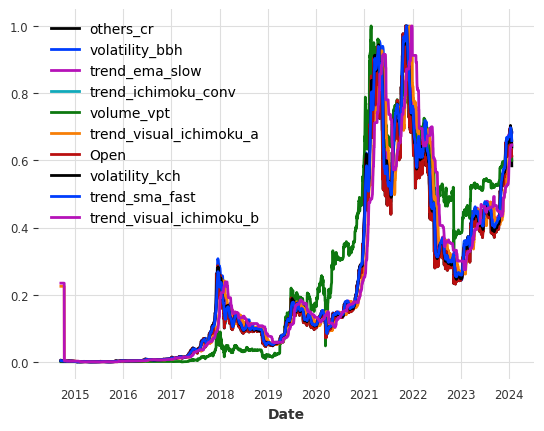

In [ ]:
past_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
        covs,
    ],
    axis="component",
)


scaler_ft_past = Scaler()

past_covs = scaler_ft_past.fit_transform(past_covs)
idx = past_covs.columns[6:]
tech_analysis_idx = past_covs[idx.to_list()]
tech_analysis_idx.plot()
plt.show()

In [ ]:
future_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
    ],
    axis="component",
)


scaler_ft_future = Scaler()


future_covs = scaler_ft_future.fit_transform(future_covs)

In [ ]:
val = scaler_target.inverse_transform(val_scaled)

test = scaler_target.inverse_transform(test_scaled)

# Create csv file where to store all of the Error Metrics

In [ ]:
import csv

headers = ['Model', 'MAE', 'RMSE', 'MSE', 'MAPE']
separator = ['-', '-', '-', '-', '-']

with open('./results/error_metrics_BTC.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(headers)

def add_row(row):
  with open('./results/error_metrics_BTC.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(row)

# Naive models

In [ ]:
models = {}
predictions = {}

models['naive_drift_model'] = NaiveDrift()
models['naive_model'] = NaiveSeasonal()
models['naive_seasonal_model'] = NaiveSeasonal(7)


for key, model in models.items():
    model.fit(train_scaled)
    predictions[key] = model.predict(len(val_scaled))
    predictions[key] = scaler_target.inverse_transform(predictions[key])

In [ ]:
print_graph(val, predictions, False, None)

In [ ]:
for key, prediction in predictions.items():
    print(f"MAE of {key}: {mae(val, prediction)}")
    print(f"RMSE of {key}: {rmse(val, prediction)}")
    print(f"MSE of {key}: {mse(val, prediction)}")
    print(f"MAPE of {key}: {mape(val, prediction)}")
    print("\n")
    row = [f'{key}', mae(val, prediction), rmse(val, prediction), mse(val, prediction), mape(val, prediction) ]
    add_row(row)

add_row(separator)

MAE of naive_drift_model: 1800.8917236328125
RMSE of naive_drift_model: 2743.376953125
MSE of naive_drift_model: 7526116.5
MAPE of naive_drift_model: 8.578919619321823


MAE of naive_model: 1855.870849609375
RMSE of naive_model: 2822.851806640625
MSE of naive_model: 7968493.0
MAPE of naive_model: 8.841709792613983


MAE of naive_seasonal_model: 1907.3856201171875
RMSE of naive_seasonal_model: 2853.248046875
MSE of naive_seasonal_model: 8141025.0
MAPE of naive_seasonal_model: 9.125959873199463




# Backtesting Naive Drift Model

In [ ]:
bt_horizons = [1, 7 ,30]
bt_start=test_target.time_index[0]


In [ ]:
backtesting_Drift = []
backtesting_Naive = []
backtesting_NaiveSeasonal = []
backtesting_ExpSmoothing = []
backtesting_Arima = []
backtesting_Prophet = []
backtesting_Tbats = []

In [ ]:

for h in bt_horizons:
  hist_Drift = models['naive_drift_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Drift = scaler_target.inverse_transform(hist_Drift)
  backtesting_Drift.append(hist_predict_Drift)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [ ]:
len(backtesting_Drift)

3

In [ ]:
for b in backtesting_Drift:
  h = bt_horizons[backtesting_Drift.index(b)]
  print_graph_backtesting(test, b, True, 'naive_drift_model',h)

In [ ]:
add_row(['Backtesting Naive Drift Model','','','',''])
for b in backtesting_Drift:
  print(f"MAE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Drift fh={bt_horizons[backtesting_Drift.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Drift Model forecasting horizon = 1: 476.2523193359375
RMSE of Naive Drift Model forecasting horizon = 1: 725.2330322265625
MSE of Naive Drift Model forecasting horizon = 1: 525962.9375
MAPE of Naive Drift Model forecasting horizon = 1: 1.5522055327892303


MAE of Naive Drift Model forecasting horizon = 7: 1328.9774169921875
RMSE of Naive Drift Model forecasting horizon = 7: 1891.774169921875
MSE of Naive Drift Model forecasting horizon = 7: 3578809.5
MAPE of Naive Drift Model forecasting horizon = 7: 4.350427538156509


MAE of Naive Drift Model forecasting horizon = 30: 3096.5166015625
RMSE of Naive Drift Model forecasting horizon = 30: 3882.038818359375
MSE of Naive Drift Model forecasting horizon = 30: 15070226.0
MAPE of Naive Drift Model forecasting horizon = 30: 9.717575460672379




# Backtesting Naive Model

In [ ]:
for h in bt_horizons:
  hist_Naive = models['naive_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Naive = scaler_target.inverse_transform(hist_Naive)
  backtesting_Naive.append(hist_predict_Naive)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [ ]:
for b in backtesting_Naive:
  h = bt_horizons[backtesting_Naive.index(b)]
  print_graph_backtesting(test, b, True, 'naive_model',h)

In [ ]:
add_row(['Backtesting Naive Model','','','',''])
for b in backtesting_Naive:
  print(f"MAE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive fh={bt_horizons[backtesting_Naive.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Model forecasting horizon = 1: 475.8396301269531
RMSE of Naive Model forecasting horizon = 1: 725.6587524414062
MSE of Naive Model forecasting horizon = 1: 526580.625
MAPE of Naive Model forecasting horizon = 1: 1.550288125872612


MAE of Naive Model forecasting horizon = 7: 1330.9739990234375
RMSE of Naive Model forecasting horizon = 7: 1901.690185546875
MSE of Naive Model forecasting horizon = 7: 3616425.75
MAPE of Naive Model forecasting horizon = 7: 4.347711428999901


MAE of Naive Model forecasting horizon = 30: 3149.355712890625
RMSE of Naive Model forecasting horizon = 30: 3991.0166015625
MSE of Naive Model forecasting horizon = 30: 15928213.0
MAPE of Naive Model forecasting horizon = 30: 9.825743734836578




# Backtesting Naive Seasonal Model

In [ ]:
for h in bt_horizons:
  hist_NaiveSeasonal = models['naive_seasonal_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_NaiveSeasonal = scaler_target.inverse_transform(hist_NaiveSeasonal)
  backtesting_NaiveSeasonal.append(hist_predict_NaiveSeasonal)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [ ]:
for b in backtesting_NaiveSeasonal:
  h = bt_horizons[backtesting_NaiveSeasonal.index(b)]
  print_graph_backtesting(test, b, True, 'naive_seasonal_model',h)

In [ ]:
add_row(['Backtesting Naive Seasonal Model','','','',''])
for b in backtesting_NaiveSeasonal:
  print(f"MAE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Seasonal fh={bt_horizons[backtesting_NaiveSeasonal.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Seasonal Model forecasting horizon = 1: 1331.7537841796875
RMSE of Naive Seasonal Model forecasting horizon = 1: 1897.005615234375
MSE of Naive Seasonal Model forecasting horizon = 1: 3598630.25
MAPE of Naive Seasonal Model forecasting horizon = 1: 4.374900087714195


MAE of Naive Seasonal Model forecasting horizon = 7: 1330.9739990234375
RMSE of Naive Seasonal Model forecasting horizon = 7: 1901.690185546875
MSE of Naive Seasonal Model forecasting horizon = 7: 3616425.75
MAPE of Naive Seasonal Model forecasting horizon = 7: 4.347711428999901


MAE of Naive Seasonal Model forecasting horizon = 30: 3585.091552734375
RMSE of Naive Seasonal Model forecasting horizon = 30: 4454.36279296875
MSE of Naive Seasonal Model forecasting horizon = 30: 19841350.0
MAPE of Naive Seasonal Model forecasting horizon = 30: 11.135898530483246




# Graphs of the Naive Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [ ]:
predictions_naive_1= {}
predictions_naive_7= {}
predictions_naive_30= {}

naive_models = ['Naive', 'Naive Drift', 'Naive Seasonal']
backtesting_naive =[backtesting_Naive, backtesting_Drift, backtesting_NaiveSeasonal]
predictions_naive = [predictions_naive_1, predictions_naive_7, predictions_naive_30]

for i in predictions_naive:
    for j in naive_models:
        i[j] = backtesting_naive[naive_models.index(j)][predictions_naive.index(i)]

In [ ]:
#print

print_graph_backtesting(test, predictions_naive_1, False, None, 1)
print_graph_backtesting(test, predictions_naive_7, False, None, 7)
print_graph_backtesting(test, predictions_naive_30, False, None, 30)


# Random Forest

In [ ]:
from darts.models import RandomForest

random_forest_model = RandomForest(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    n_estimators=100,  # Number of trees in the forest
    max_depth=15,  # Maximum depth of each tree
)

In [ ]:
random_forest_model.fit(train_scaled, past_covariates = past_covs)
random_forest_prediction = random_forest_model.predict(n = len(val_scaled))
random_forest_prediction = scaler_target.inverse_transform(random_forest_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [ ]:
print_graph(val, random_forest_prediction, True, 'Random Forest')

In [ ]:
print(f"MAE of Random Forest: {mae(val, random_forest_prediction)}")
print(f"RMSE of Random Forest: {rmse(val, random_forest_prediction)}")
print(f"MSE of Random Forest: {mse(val, random_forest_prediction)}")
print(f"MAPE of Random Forest: {mape(val, random_forest_prediction)}")
row = ['Random Forest', mae(val, random_forest_prediction), rmse(val, random_forest_prediction), mse(val, random_forest_prediction), mape(val, random_forest_prediction) ]
add_row(row)
add_row(separator)

MAE of Random Forest: 683.1752482697564
RMSE of Random Forest: 1058.7109789552655
MSE of Random Forest: 1120868.9369604166
MAPE of Random Forest: 3.468199498257914


# Backtesting Random Forest

In [ ]:
backtesting_RF = []

bt_horizons = [1, 7 ,30]

bt_start=test.time_index[0]

for h in bt_horizons:

  hist_RF = random_forest_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_RF = scaler_target.inverse_transform(hist_RF)
  backtesting_RF.append(hist_predict_RF)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/359 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [ ]:
for b in backtesting_RF:
  h = bt_horizons[backtesting_RF.index(b)]
  print_graph_backtesting(test, b, True, 'Random Forest',h)

In [ ]:
add_row(['Backtesting Random Forest','','','',''])
for b in backtesting_RF:
  print(f"MAE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Random Forest fh={bt_horizons[backtesting_RF.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RF forecasting horizon = 1: 3280.6224199473104
RMSE of RF forecasting horizon = 1: 3834.216223857263
MSE of RF forecasting horizon = 1: 14701214.051290246
MAPE of RF forecasting horizon = 1: 11.297611675982042


MAE of RF forecasting horizon = 7: 3662.348266043883
RMSE of RF forecasting horizon = 7: 4256.592738639859
MSE of RF forecasting horizon = 7: 18118581.742641572
MAPE of RF forecasting horizon = 7: 12.6139788591217


MAE of RF forecasting horizon = 30: 3859.2645575481693
RMSE of RF forecasting horizon = 30: 4384.727247496443
MSE of RF forecasting horizon = 30: 19225833.034937732
MAPE of RF forecasting horizon = 30: 13.247587660643273




# LSTM Model

Best parameters: {'hidden_dim': 104,
 'r_rnn_layers': 4,
 'dropout': 0.18390991552139796,
 'lr': 0.00014678997505613995,
 'encoders': False}

In [ ]:
LSTM_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_dim=104,
    model='LSTM',
    n_rnn_layers=4,
    dropout=0.18390991552139796,
    optimizer_kwargs={'lr': 0.00014678997505613995},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [ ]:
LSTM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 319 K 
4 | fc            | Sequential       | 735   
---------------------------------------------------
320 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=LSTM, hidden_dim=104, n_rnn_layers=4, hidden_fc_sizes=None, dropout=0.18390991552139796, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00014678997505613995}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000024D1DE0EF10>]})

In [ ]:
LSTM_model_prediction = LSTM_model.predict(n = len(val_scaled))
LSTM_model_prediction = scaler_target.inverse_transform(LSTM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print_graph(val, LSTM_model_prediction, True, 'LSTM model')

In [ ]:
print(f"MAE of LSTM: {mae(val, LSTM_model_prediction)}")
print(f"RMSE of LSTM: {rmse(val, LSTM_model_prediction)}")
print(f"MSE of LSTM: {mse(val, LSTM_model_prediction)}")
print(f"MAPE of LSTM: {mape(val, LSTM_model_prediction)}")
row = ['LSTM', mae(val, LSTM_model_prediction), rmse(val, LSTM_model_prediction), mse(val, LSTM_model_prediction), mape(val, LSTM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LSTM: 2471.795654296875
RMSE of LSTM: 2766.240478515625
MSE of LSTM: 7652087.0
MAPE of LSTM: 12.972185015678406


# Backtesting LSTM

In [ ]:
backtesting_LSTM = []

for h in bt_horizons:

  hist_LSTM = LSTM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_LSTM = scaler_target.inverse_transform(hist_LSTM)
  backtesting_LSTM.append(hist_predict_LSTM)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for b in backtesting_LSTM:
  h = bt_horizons[backtesting_LSTM.index(b)]
  print_graph_backtesting(test, b, True, 'LSTM model',h)

In [ ]:
add_row(['Backtesting LSTM Model','','','',''])
for b in backtesting_LSTM:
  print(f"MAE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LSTM fh={bt_horizons[backtesting_LSTM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of LSTM forecasting horizon = 1: 2308.829345703125
RMSE of LSTM forecasting horizon = 1: 2641.9208984375
MSE of LSTM forecasting horizon = 1: 6979746.5
MAPE of LSTM forecasting horizon = 1: 7.652677595615387


MAE of LSTM forecasting horizon = 7: 3032.5537109375
RMSE of LSTM forecasting horizon = 7: 3382.82568359375
MSE of LSTM forecasting horizon = 7: 11443509.0
MAPE of LSTM forecasting horizon = 7: 10.22125706076622


MAE of LSTM forecasting horizon = 30: 3287.03955078125
RMSE of LSTM forecasting horizon = 30: 3626.306884765625
MSE of LSTM forecasting horizon = 30: 13150101.0
MAPE of LSTM forecasting horizon = 30: 10.968698561191559




# VanillaRNN Model

Best parameters:
{'hidden_dim': 31,
 'n_rnn_layers': 1,
 'dropout': 0.34008569567908437,
 'lr': 0.0009241588491743642,
 'encoders': False}

In [ ]:
vanillaRNN_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='RNN',
    hidden_dim=31,
    n_rnn_layers=1,
    dropout=0.34008569567908437,
    optimizer_kwargs={'lr': 0.0009241588491743642},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [ ]:
vanillaRNN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.34008569567908437 and num_layers=1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 224   
---------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=RNN, hidden_dim=31, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.34008569567908437, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0009241588491743642}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000024EF8882590>]})

In [ ]:
vanillaRNN_model_prediction = vanillaRNN_model.predict(n = len(val_scaled))
vanillaRNN_model_prediction = scaler_target.inverse_transform(vanillaRNN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print_graph(val, vanillaRNN_model_prediction, True, 'Vanilla RNN')

In [ ]:
print(f"MAE of VanillaRNN: {mae(val, vanillaRNN_model_prediction)}")
print(f"RMSE of VanillaRNN: {rmse(val, vanillaRNN_model_prediction)}")
print(f"MSE of VanillaRNN: {mse(val, vanillaRNN_model_prediction)}")
print(f"MAPE of VanillaRNN: {mape(val, vanillaRNN_model_prediction)}")
row = ['VanillaRNN', mae(val, vanillaRNN_model_prediction), rmse(val, vanillaRNN_model_prediction), mse(val, vanillaRNN_model_prediction), mape(val, vanillaRNN_model_prediction)]
add_row(row)
add_row(separator)

MAE of VanillaRNN: 2197.261962890625
RMSE of VanillaRNN: 2644.856689453125
MSE of VanillaRNN: 6995266.5
MAPE of VanillaRNN: 11.458475142717361


# Backtesting VanillaRNN

In [ ]:
backtesting_VanillaRNN = []

for h in bt_horizons:

  hist_VanillaRNN = vanillaRNN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_VanillaRNN = scaler_target.inverse_transform(hist_VanillaRNN)
  backtesting_VanillaRNN.append(hist_predict_VanillaRNN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for b in backtesting_VanillaRNN:
  h = bt_horizons[backtesting_VanillaRNN.index(b)]
  print_graph_backtesting(test, b, True, 'Vanilla RNN',h)

In [ ]:
add_row(['Backtesting RNN Model','','','',''])
for b in backtesting_VanillaRNN:
  print(f"MAE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'RNN fh={bt_horizons[backtesting_VanillaRNN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RNN forecasting horizon = 1: 1389.31298828125
RMSE of RNN forecasting horizon = 1: 1666.451171875
MSE of RNN forecasting horizon = 1: 2777059.5
MAPE of RNN forecasting horizon = 1: 4.553504660725594


MAE of RNN forecasting horizon = 7: 1521.137939453125
RMSE of RNN forecasting horizon = 7: 2150.387939453125
MSE of RNN forecasting horizon = 7: 4624168.5
MAPE of RNN forecasting horizon = 7: 4.924555122852325


MAE of RNN forecasting horizon = 30: 1555.4228515625
RMSE of RNN forecasting horizon = 30: 2214.613037109375
MSE of RNN forecasting horizon = 30: 4904511.0
MAPE of RNN forecasting horizon = 30: 4.940137267112732




# GRU Model

Best parameters: {'hidden_dim': 75,
 'r_rnn_layers': 1,
 'dropout': 0.007824503730612165,
 'lr': 0.000566687831423731,
 'encoders': False}

In [ ]:
GRU_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='GRU',
    hidden_dim=75,
    n_rnn_layers=1,
    dropout=0.007824503730612165,
    optimizer_kwargs={'lr': 0.000566687831423731},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [ ]:
GRU_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.007824503730612165 and num_layers=1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 24.5 K
4 | fc            | Sequential       | 532   
---------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=GRU, hidden_dim=75, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.007824503730612165, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.000566687831423731}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000024EF8957710>]})

In [ ]:
GRU_model_prediction = GRU_model.predict(n = len(val_scaled))
GRU_model_prediction = scaler_target.inverse_transform(GRU_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print_graph(val, GRU_model_prediction, True, 'GRU Model')

In [ ]:
print(f"MAE of GRU: {mae(val, GRU_model_prediction)}")
print(f"RMSE of GRU: {rmse(val, GRU_model_prediction)}")
print(f"MSE of GRU: {mse(val, GRU_model_prediction)}")
print(f"MAPE of GRU: {mape(val, GRU_model_prediction)}")
row = ['GRU Model', mae(val, GRU_model_prediction), rmse(val, GRU_model_prediction), mse(val, GRU_model_prediction), mape(val, GRU_model_prediction) ]
add_row(row)
add_row(separator)

MAE of GRU: 1444.9620361328125
RMSE of GRU: 1703.11767578125
MSE of GRU: 2900610.0
MAPE of GRU: 7.644455134868622


# Backtesting GRU

In [ ]:
backtesting_GRU = []

for h in bt_horizons:

  hist_GRU = GRU_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_GRU = scaler_target.inverse_transform(hist_GRU)
  backtesting_GRU.append(hist_predict_GRU)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for b in backtesting_GRU:
  h = bt_horizons[backtesting_GRU.index(b)]
  print_graph_backtesting(test, b, True, 'GRU model',h)

In [ ]:
add_row(['Backtesting GRU Model','','','',''])
for b in backtesting_GRU:
  print(f"MAE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mae(test, b)}")
  print(f"RMSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {rmse(test, b)}")
  print(f"MSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mse(test, b)}")
  print(f"MAPE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'GRU fh={bt_horizons[backtesting_GRU.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of GRU forecasting horizon = 1: 1488.8240966796875
RMSE of GRU forecasting horizon = 1: 1665.4664306640625
MSE of GRU forecasting horizon = 1: 2773778.25
MAPE of GRU forecasting horizon = 1: 5.075389891862869


MAE of GRU forecasting horizon = 7: 1528.37255859375
RMSE of GRU forecasting horizon = 7: 1940.30029296875
MSE of GRU forecasting horizon = 7: 3764765.25
MAPE of GRU forecasting horizon = 7: 5.301862955093384


MAE of GRU forecasting horizon = 30: 1602.8348388671875
RMSE of GRU forecasting horizon = 30: 2008.485107421875
MSE of GRU forecasting horizon = 30: 4034012.25
MAPE of GRU forecasting horizon = 30: 5.47875240445137




# Transformer Model

Best params: {'d_model': 88, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dropout': 0.14295488378943239, 'lr': 0.00046254166100837376, 'encoders': False}

In [ ]:
transformer_model = TransformerModel(
    input_chunk_length = 21,
    output_chunk_length = 7,
    d_model=88,
    nhead=4,
    num_encoder_layers=4,
    num_decoder_layers=1,
    dropout=0.14295488378943239,
    optimizer_kwargs={'lr': 0.00046254166100837376},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [ ]:
transformer_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 2.9 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 643 K 
6 | decoder             | Linear              | 623   
------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TransformerModel(d_model=88, nhead=4, num_encoder_layers=4, num_decoder_layers=1, dim_feedforward=512, dropout=0.14295488378943239, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00046254166100837376}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000024EE484C050>]})

In [ ]:
transformer_model_prediction = transformer_model.predict(n = len(val_scaled))
transformer_model_prediction = scaler_target.inverse_transform(transformer_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print_graph(val, transformer_model_prediction, True, 'Transformer Model')

In [ ]:
print(f"MAE of Transformer Model: {mae(val, transformer_model_prediction)}")
print(f"RMSE of Transformer Model: {rmse(val, transformer_model_prediction)}")
print(f"MSE of Transformer Model: {mse(val, transformer_model_prediction)}")
print(f"MAPE of Transformer Model: {mape(val, transformer_model_prediction)}")
row = ['Transformer Model', mae(val, transformer_model_prediction), rmse(val, transformer_model_prediction), mse(val, transformer_model_prediction), mape(val, transformer_model_prediction) ]
add_row(row)
add_row(separator)

MAE of Transformer Model: 2390.357666015625
RMSE of Transformer Model: 3185.834228515625
MSE of Transformer Model: 10149539.0
MAPE of Transformer Model: 11.796802282333374


# Backtesting Transformer Model

In [ ]:
backtesting_Transformer = []

for h in bt_horizons:

  hist_Transformer = transformer_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_Transformer = scaler_target.inverse_transform(hist_Transformer)
  backtesting_Transformer.append(hist_predict_Transformer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for b in backtesting_Transformer:
  h = bt_horizons[backtesting_Transformer.index(b)]
  print_graph_backtesting(test, b, True, 'Transformer Model',h)

In [ ]:
add_row(['Backtesting Transformer Model','','','',''])
for b in backtesting_Transformer:
  print(f"MAE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Transformer fh={bt_horizons[backtesting_Transformer.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Transformer Model forecasting horizon = 1: 1459.458740234375
RMSE of Transformer Model forecasting horizon = 1: 1863.744384765625
MSE of Transformer Model forecasting horizon = 1: 3473543.0
MAPE of Transformer Model forecasting horizon = 1: 4.638635739684105


MAE of Transformer Model forecasting horizon = 7: 2064.07861328125
RMSE of Transformer Model forecasting horizon = 7: 2617.354248046875
MSE of Transformer Model forecasting horizon = 7: 6850543.0
MAPE of Transformer Model forecasting horizon = 7: 6.605726480484009


MAE of Transformer Model forecasting horizon = 30: 2333.19970703125
RMSE of Transformer Model forecasting horizon = 30: 2968.3349609375
MSE of Transformer Model forecasting horizon = 30: 8811013.0
MAPE of Transformer Model forecasting horizon = 30: 7.264932245016098




# TFT Model

best parameters: {'hidden_size': 30,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.06118422728497173,
 'hidden_continuous_size': 10,
 'lr': 0.005081664304452033}

In [ ]:
TFT_model = TFTModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_size=30,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.06118422728497173,
    hidden_continuous_size=10,
    optimizer_kwargs={'lr': 0.005081664304452033},
)

In [ ]:
TFT_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    future_covariates = future_covs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 55.7 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 7.0 K 
6  | static_context_grn                | _GatedResidualNetwork            | 3.8 K 
7  | static_context_hidden_encoder_grn | _GatedResid

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TFTModel(hidden_size=30, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.06118422728497173, hidden_continuous_size=10, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.005081664304452033})

In [ ]:
TFT_model_prediction = TFT_model.predict(n = len(val_scaled))
TFT_model_prediction = scaler_target.inverse_transform(TFT_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print_graph(val, TFT_model_prediction, True, 'TFT Model')

In [ ]:
print(f"MAE of TFT Model: {mae(val, TFT_model_prediction)}")
print(f"RMSE of TFT Model: {rmse(val, TFT_model_prediction)}")
print(f"MSE of TFT Model: {mse(val, TFT_model_prediction)}")
print(f"MAPE of TFT Model: {mape(val, TFT_model_prediction)}")
row = ['TFT', mae(val, TFT_model_prediction), rmse(val, TFT_model_prediction), mse(val, TFT_model_prediction), mape(val, TFT_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TFT Model: 3024.21826171875
RMSE of TFT Model: 4268.92529296875
MSE of TFT Model: 18223722.0
MAPE of TFT Model: 14.7584468126297


# Backtesting TFT Model

In [ ]:
backtesting_TFT = []

for h in bt_horizons:

  hist_TFT = TFT_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          future_covariates = future_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TFT = scaler_target.inverse_transform(hist_TFT)
  backtesting_TFT.append(hist_predict_TFT)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for b in backtesting_TFT:
  h = bt_horizons[backtesting_TFT.index(b)]
  print_graph_backtesting(test, b, True, 'TFT Model',h)

In [ ]:
add_row(['Backtesting TFT Model','','','',''])
for b in backtesting_TFT:
  print(f"MAE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TFT fh={bt_horizons[backtesting_TFT.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TFT Model forecasting horizon = 1: 3956.784912109375
RMSE of TFT Model forecasting horizon = 1: 4743.810546875
MSE of TFT Model forecasting horizon = 1: 22503740.0
MAPE of TFT Model forecasting horizon = 1: 13.86825293302536


MAE of TFT Model forecasting horizon = 7: 4571.29248046875
RMSE of TFT Model forecasting horizon = 7: 5479.09716796875
MSE of TFT Model forecasting horizon = 7: 30020508.0
MAPE of TFT Model forecasting horizon = 7: 15.67070335149765


MAE of TFT Model forecasting horizon = 30: 5458.21875
RMSE of TFT Model forecasting horizon = 30: 6242.8642578125
MSE of TFT Model forecasting horizon = 30: 38973356.0
MAPE of TFT Model forecasting horizon = 30: 18.58578473329544




# NBEATS Model

Best parameters: {'num_stacks': 19,
 'num_blocks': 4,
 'num_layers': 4,
 'layer_widths': 378,
 'expansion_coefficient_dim': 8,
 'dropout': 0.007293860107310261,
 'lr': 0.0005903374698873167,
 'encoders': True}

In [ ]:
from darts.models import NBEATSModel

NBEATS_model = NBEATSModel(
    input_chunk_length=21,
    output_chunk_length=7,
    num_stacks=19,
    num_blocks=4,
    num_layers=4,
    layer_widths=378,
    expansion_coefficient_dim=8,
    dropout=0.007293860107310261,
    add_encoders =  {
        'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']},  # Capture seasonal trends
        'datetime_attribute': {'past': ['day', 'week', 'year']},
        'position': {'past': ['relative']},
        'transformer': Scaler(),
    },
    optimizer_kwargs={'lr': 0.0005903374698873167},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [ ]:

NBEATS_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 59.3 M
---------------------------------------------------
59.3 M    Trainable params
11.0 K    Non-trainable params
59.3 M    Total params
237.183   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=19, num_blocks=4, num_layers=4, layer_widths=378, expansion_coefficient_dim=8, trend_polynomial_degree=2, dropout=0.007293860107310261, activation=ReLU, input_chunk_length=21, output_chunk_length=7, add_encoders={'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']}, 'datetime_attribute': {'past': ['day', 'week', 'year']}, 'position': {'past': ['relative']}, 'transformer': Scaler}, optimizer_kwargs={'lr': 0.0005903374698873167}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000024EE424D010>]})

In [ ]:
NBEATS_model_prediction = NBEATS_model.predict(n=len(val_scaled))
NBEATS_model_prediction = scaler_target.inverse_transform(NBEATS_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print_graph(val, NBEATS_model_prediction, True, 'NBEATS Model')

In [ ]:
print(f"MAE of NBEATS: {mae(val, NBEATS_model_prediction)}")
print(f"RMSE of NBEATS: {rmse(val, NBEATS_model_prediction)}")
print(f"MSE of NBEATS: {mse(val, NBEATS_model_prediction)}")
print(f"MAPE of NBEATS: {mape(val, NBEATS_model_prediction)}")
row = ['NBEATS', mae(val, NBEATS_model_prediction), rmse(val, NBEATS_model_prediction), mse(val, NBEATS_model_prediction), mape(val, NBEATS_model_prediction) ]
add_row(row)
add_row(separator)

MAE of NBEATS: 3156.843017578125
RMSE of NBEATS: 4079.793701171875
MSE of NBEATS: 16644717.0
MAPE of NBEATS: 15.686477720737457


# Backtesting NBEATS Model

In [ ]:
backtesting_NBEATS = []

for h in bt_horizons:

  hist_NBEATS = NBEATS_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_NBEATS = scaler_target.inverse_transform(hist_NBEATS)
  backtesting_NBEATS.append(hist_predict_NBEATS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for b in backtesting_NBEATS:
  h = bt_horizons[backtesting_NBEATS.index(b)]
  print_graph_backtesting(test, b, True, 'NBEATS Model',h)

In [ ]:
add_row(['Backtesting NBEATS Model','','','',''])
for b in backtesting_NBEATS:
  print(f"MAE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mae(test, b)}")
  print(f"RMSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {rmse(test, b)}")
  print(f"MSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mse(test, b)}")
  print(f"MAPE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'NBEATS fh={bt_horizons[backtesting_NBEATS.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of NBEATS Model forecasting horizon = 1: 2185.899658203125
RMSE of NBEATS Model forecasting horizon = 1: 2610.60498046875
MSE of NBEATS Model forecasting horizon = 1: 6815258.0
MAPE of NBEATS Model forecasting horizon = 1: 7.366064935922623


MAE of NBEATS Model forecasting horizon = 7: 2878.53857421875
RMSE of NBEATS Model forecasting horizon = 7: 3643.12890625
MSE of NBEATS Model forecasting horizon = 7: 13272388.0
MAPE of NBEATS Model forecasting horizon = 7: 9.588178992271423


MAE of NBEATS Model forecasting horizon = 30: 3057.443359375
RMSE of NBEATS Model forecasting horizon = 30: 3850.454833984375
MSE of NBEATS Model forecasting horizon = 30: 14826002.0
MAPE of NBEATS Model forecasting horizon = 30: 10.038228332996368




# TCN Model

Best parameters: {'kernel_size': 8,
 'num_filters': 36,
 'weight_norm': False,
 'dilation_base': 2,
 'dropout': 0.14321708644925318,
 'lr': 0.0005056311276120884,
 'encoders': True}

In [ ]:
TCN_model = TCNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    kernel_size=8,
    num_filters=36,
    weight_norm= False,
    dilation_base=2,
    dropout= 0.14321708644925318,
    optimizer_kwargs={'lr': 0.0005056311276120884},
    random_state=0,
    add_encoders = {
        'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']},  # Capture seasonal trends
        'datetime_attribute': {'past': ['day', 'week', 'year']},
        'position': {'past': ['relative']},
        'transformer': Scaler(),
    }
)

In [ ]:
TCN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 34.8 K
----------------------------------------------------
34.8 K    Trainable params
0         Non-trainable params
34.8 K    Total params
0.139     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TCNModel(kernel_size=8, num_filters=36, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.14321708644925318, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0005056311276120884}, random_state=0, add_encoders={'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']}, 'datetime_attribute': {'past': ['day', 'week', 'year']}, 'position': {'past': ['relative']}, 'transformer': Scaler})

In [ ]:
TCN_model_prediction = TCN_model.predict(n = len(val_scaled))
TCN_model_prediction = scaler_target.inverse_transform(TCN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print_graph(val, TCN_model_prediction, True, 'TCN Model')

In [ ]:
print(f"MAE of TCN: {mae(val, TCN_model_prediction)}")
print(f"RMSE of TCN: {rmse(val, TCN_model_prediction)}")
print(f"MSE of TCN: {mse(val, TCN_model_prediction)}")
print(f"MAPE of TCN: {mape(val, TCN_model_prediction)}")
row = ['TCN', mae(val, TCN_model_prediction), rmse(val, TCN_model_prediction), mse(val, TCN_model_prediction), mape(val, TCN_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TCN: 1688.636962890625
RMSE of TCN: 2223.57080078125
MSE of TCN: 4944267.5
MAPE of TCN: 8.383679389953613


# Backtesting TCN Model

In [ ]:
backtesting_TCN = []

for h in bt_horizons:

  hist_TCN = TCN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TCN = scaler_target.inverse_transform(hist_TCN)
  backtesting_TCN.append(hist_predict_TCN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for b in backtesting_TCN:
  h = bt_horizons[backtesting_TCN.index(b)]
  print_graph_backtesting(test, b, True, 'TCN Model',h)

In [ ]:
add_row(['Backtesting TCN Model','','','',''])
for b in backtesting_TCN:
  print(f"MAE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TCN fh={bt_horizons[backtesting_TCN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TCN Model forecasting horizon = 1: 3017.253173828125
RMSE of TCN Model forecasting horizon = 1: 4174.2412109375
MSE of TCN Model forecasting horizon = 1: 17424290.0
MAPE of TCN Model forecasting horizon = 1: 10.06162017583847


MAE of TCN Model forecasting horizon = 7: 3026.447021484375
RMSE of TCN Model forecasting horizon = 7: 4183.7041015625
MSE of TCN Model forecasting horizon = 7: 17503378.0
MAPE of TCN Model forecasting horizon = 7: 10.043437033891678


MAE of TCN Model forecasting horizon = 30: 3336.2763671875
RMSE of TCN Model forecasting horizon = 30: 4488.7470703125
MSE of TCN Model forecasting horizon = 30: 20148852.0
MAPE of TCN Model forecasting horizon = 30: 10.961858183145523




# Graphs of the DL Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [ ]:
predictions_DL_1= {}
predictions_DL_7= {}
predictions_DL_30= {}

DL_models = ['LSTM', 'RNN', 'GRU', 'Transformer', 'TFT', 'NBEATS', 'TCN']
backtesting_DL =[backtesting_LSTM, backtesting_VanillaRNN, backtesting_GRU, backtesting_Transformer, backtesting_TFT, backtesting_NBEATS, backtesting_TCN] 
predictions_DL = [predictions_DL_1, predictions_DL_7, predictions_DL_30]

for i in predictions_DL:
    for j in DL_models:
        i[j] = backtesting_DL[DL_models.index(j)][predictions_DL.index(i)]

In [ ]:
print_graph_backtesting(test, predictions_DL_1, False, None, 1)
print_graph_backtesting(test, predictions_DL_7, False, None, 7)
print_graph_backtesting(test, predictions_DL_30, False, None, 30)

# LightGBM Model

In [ ]:
from darts.models.forecasting.lgbm import LightGBMModel

LightGBM_model = LightGBMModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    output_chunk_length = 7,
)

In [ ]:
LightGBM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,

)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210240
[LightGBM] [Info] Number of data points in the train set: 2836, number of used features: 962
[LightGBM] [Info] Start training from score 0.199794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210240
[LightGBM] [Info] Number of data points in the train set: 2836, number of used features: 962
[LightGBM] [Info] Start training from score 0.199881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210240
[LightGBM] [Info] Number of data points in the train set: 2836, number of used features: 962
[LightGBM] [Info] Sta

LightGBMModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [ ]:
LightGBM_model_prediction = LightGBM_model.predict(n = len(val_scaled))
LightGBM_model_prediction = scaler_target.inverse_transform(LightGBM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [ ]:
print_graph(val, LightGBM_model_prediction,True, 'LightGBM Model')

In [ ]:
print(f"MAE of LightGBM: {mae(val, LightGBM_model_prediction)}")
print(f"RMSE of LightGBM: {rmse(val, LightGBM_model_prediction)}")
print(f"MSE of LightGBM: {mse(val, LightGBM_model_prediction)}")
print(f"MAPE of LightGBM: {mape(val, LightGBM_model_prediction)}")
row = ['LightGBM', mae(val, LightGBM_model_prediction), rmse(val, LightGBM_model_prediction), mse(val, LightGBM_model_prediction), mape(val, LightGBM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LightGBM: 2098.378264374115
RMSE of LightGBM: 2759.790832307127
MSE of LightGBM: 7616445.438086464
MAPE of LightGBM: 10.411583477929335


# Backtesting LightGBM Model

In [ ]:
backtesting_LightGBM = []

for h in bt_horizons:
  hist_LightGBM = LightGBM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )
  hist_predict_LightGBM = scaler_target.inverse_transform(hist_LightGBM)
  backtesting_LightGBM.append(hist_predict_LightGBM)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [ ]:
for b in backtesting_LightGBM:
  h = bt_horizons[backtesting_LightGBM.index(b)]
  print_graph_backtesting(test, b, True, 'LightGBM Model',h)

In [ ]:
add_row(['Backtesting LightGBM Model','','','',''])
for b in backtesting_LightGBM:
  print(f"MAE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LightGBM fh={bt_horizons[backtesting_LightGBM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)


MAE of LightGBM forecasting horizon = 1: 1712.2130519866446
RMSE of LightGBM forecasting horizon = 1: 2009.124174818862
MSE of LightGBM forecasting horizon = 1: 4036579.9498415734
MAPE of LightGBM forecasting horizon = 1: 5.738220296162854


MAE of LightGBM forecasting horizon = 7: 5354.736536062496
RMSE of LightGBM forecasting horizon = 7: 5916.018961336046
MSE of LightGBM forecasting horizon = 7: 34999280.35088763
MAPE of LightGBM forecasting horizon = 7: 18.261083976610763


MAE of LightGBM forecasting horizon = 30: 6670.081430866361
RMSE of LightGBM forecasting horizon = 30: 7199.515405041837
MSE of LightGBM forecasting horizon = 30: 51833022.06743473
MAPE of LightGBM forecasting horizon = 30: 22.634520065203944




# XGB Model

In [ ]:
from darts.models import XGBModel

XGB_model = XGBModel (
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    output_chunk_length = 7,
)

In [ ]:
XGB_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

XGBModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [ ]:
XGB_model_prediction = XGB_model.predict(n = len(val))
XGB_model_prediction = scaler_target.inverse_transform(XGB_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [ ]:
print_graph(val, XGB_model_prediction, True, 'XGB Model')

In [ ]:
print(f"MAE of XGB: {mae(val, XGB_model_prediction)}")
print(f"RMSE of XGB: {rmse(val, XGB_model_prediction)}")
print(f"MSE of XGB: {mse(val, XGB_model_prediction)}")
print(f"MAPE of XGB: {mape(val, XGB_model_prediction)}")
row = ['XGB', mae(val, XGB_model_prediction), rmse(val, XGB_model_prediction), mse(val, XGB_model_prediction), mape(val, XGB_model_prediction) ]
add_row(row)
add_row(separator)

MAE of XGB: 3001.670654296875
RMSE of XGB: 4152.7333984375
MSE of XGB: 17245194.0
MAPE of XGB: 14.671190083026886


# Backtesting XGB Model

In [ ]:
backtesting_XGB = []

for h in bt_horizons:

  hist_XGB = XGB_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_XGB = scaler_target.inverse_transform(hist_XGB)
  backtesting_XGB.append(hist_predict_XGB)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [ ]:
for b in backtesting_XGB:
  h = bt_horizons[backtesting_XGB.index(b)]
  print_graph_backtesting(test, b, True, 'XGB Model',h)

In [ ]:
add_row(['Backtesting XGB Model','','','',''])
for b in backtesting_XGB:
  print(f"MAE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mae(test, b)}")
  print(f"RMSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {rmse(test, b)}")
  print(f"MSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mse(test, b)}")
  print(f"MAPE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'XGB fh={bt_horizons[backtesting_XGB.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of XGB forecasting horizon = 1: 2854.80224609375
RMSE of XGB forecasting horizon = 1: 3367.240234375
MSE of XGB forecasting horizon = 1: 11338306.0
MAPE of XGB forecasting horizon = 1: 9.586988389492035


MAE of XGB forecasting horizon = 7: 4639.5224609375
RMSE of XGB forecasting horizon = 7: 5348.58349609375
MSE of XGB forecasting horizon = 7: 28607348.0
MAPE of XGB forecasting horizon = 7: 16.116471588611603


MAE of XGB forecasting horizon = 30: 4712.7080078125
RMSE of XGB forecasting horizon = 30: 5386.84423828125
MSE of XGB forecasting horizon = 30: 29018090.0
MAPE of XGB forecasting horizon = 30: 16.022689640522003




# CatBoost Model

In [ ]:
from darts.models import CatBoostModel

In [ ]:
CatBoost_model = CatBoostModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    output_chunk_length = 7,
)

In [ ]:
CatBoost_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

CatBoostModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [ ]:
CatBoost_model_prediction = CatBoost_model.predict(n = len(val))
Catboost_model_prediction = scaler_target.inverse_transform(CatBoost_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [ ]:
print_graph(val, Catboost_model_prediction, True, 'CatBoost Model')

In [ ]:
print(f"MAE of CatBoost: {mae(val, CatBoost_model_prediction)}")
print(f"RMSE of CatBoost: {rmse(val, CatBoost_model_prediction)}")
print(f"MSE of CatBoost: {mse(val, CatBoost_model_prediction)}")
print(f"MAPE of CatBoost: {mape(val, CatBoost_model_prediction)}")
row = ['CatBoost', mae(val, CatBoost_model_prediction), rmse(val, CatBoost_model_prediction), mse(val, CatBoost_model_prediction), mape(val, CatBoost_model_prediction) ]
add_row(row)
add_row(separator)

MAE of CatBoost: 18577.202256775956
RMSE of CatBoost: 18710.133465054107
MSE of CatBoost: 350069094.28013766
MAPE of CatBoost: 99.99859182318261


# Backtesting CatBoost Model

In [ ]:
backtesting_CatBoost = []

for h in bt_horizons:

  hist_CatBoost = CatBoost_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_CatBoost = scaler_target.inverse_transform(hist_CatBoost)
  backtesting_CatBoost.append(hist_predict_CatBoost)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [ ]:
for b in backtesting_CatBoost:
  h = bt_horizons[backtesting_CatBoost.index(b)]
  print_graph_backtesting(test, b, True, 'CatBoost Model',h)

In [ ]:
add_row(['Backtesting Catboost Model','','','',''])
for b in backtesting_CatBoost:
  print(f"MAE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mae(test, b)}")
  print(f"RMSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {rmse(test, b)}")
  print(f"MSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mse(test, b)}")
  print(f"MAPE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Catboost fh={bt_horizons[backtesting_CatBoost.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of CatBoost forecasting horizon = 1: 1909.2920559937218
RMSE of CatBoost forecasting horizon = 1: 2392.2732740776783
MSE of CatBoost forecasting horizon = 1: 5722971.417866334
MAPE of CatBoost forecasting horizon = 1: 6.241945627090132


MAE of CatBoost forecasting horizon = 7: 2571.1171492896065
RMSE of CatBoost forecasting horizon = 7: 3142.4321443023614
MSE of CatBoost forecasting horizon = 7: 9874879.781544736
MAPE of CatBoost forecasting horizon = 7: 8.554755134031367


MAE of CatBoost forecasting horizon = 30: 2781.8909464419303
RMSE of CatBoost forecasting horizon = 30: 3361.1942120257554
MSE of CatBoost forecasting horizon = 30: 11297626.530955438
MAPE of CatBoost forecasting horizon = 30: 9.075149837927803




# Graphs of the Regression Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [ ]:
predictions_regression_1= {}
predictions_regression_7= {}
predictions_regression_30= {}

regression_models = ['Random Forest', 'LightGBM', 'XGBoost', 'CatBoost']
backtesting_regression =[backtesting_RF, backtesting_LightGBM, backtesting_XGB, backtesting_CatBoost] 
predictions_regression = [predictions_regression_1, predictions_regression_7, predictions_regression_30]

for i in predictions_regression:
    for j in regression_models:
        i[j] = backtesting_regression[regression_models.index(j)][predictions_regression.index(i)]

In [ ]:
print_graph_backtesting(test, predictions_regression_1, False, None, 1)
print_graph_backtesting(test, predictions_regression_7, False, None, 7)
print_graph_backtesting(test, predictions_regression_30, False, None, 30)